In [37]:
using Revise

In [38]:
using MeshCatMechanisms
using MeshCat
using RigidBodyDynamics
using RigidBodySim
using Flux
using JLD2
using Plots; gr()
using LCPSim
using LearningMPC
using LearningMPC.Models
using DataFrames
using Blink

In [39]:
robot = BoxAtlas(add_contacts=true)
position_bounds(findjoint(mechanism(robot), "floating_base")) .= RigidBodyDynamics.Bounds(-Inf, Inf)
mvis = MechanismVisualizer(robot)
open(mvis, Window())

Blink.AtomShell.Window(2, Blink.AtomShell.Electron(Process(`/home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Blink/deps/atom/electron /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Blink/src/AtomShell/main.js port 8477`, ProcessRunning), TCPSocket(RawFD(51) active, 0 bytes waiting), Dict{String,Any}(Pair{String,Any}("callback", Blink.#1))), Blink.Page(2, WebSockets.WebSocket{TCPSocket}(TCPSocket(RawFD(57) active, 0 bytes waiting), true, CONNECTED::WebSockets.ReadyState = 1), Dict{String,Any}(Pair{String,Any}("webio", WebIO.#111),Pair{String,Any}("callback", Blink.#1)), Future(1, 1, 2, Nullable{Any}(true))))

In [96]:
@load "boxatlas-regularized.jld2" datasets net lqrsol mpc_params
mpc_params_data = mpc_params
mpc_params = MPCParams(robot)
mpc_params.Δt = mpc_params_data["Δt"]
mpc_params.horizon = mpc_params_data["horizon"]
net_cost = LearningMPC.LearnedCost(lqrsol, net)
net_mpc_params = MPCParams(robot)
net_mpc_params.horizon = 1
net_mpc_controller = MPCController(robot, net_mpc_params, net_cost, [lqrsol]);
full_mpc_controller = MPCController(robot, mpc_params, lqrsol, [lqrsol, net_mpc_controller]);
lqr_mpc_controller = MPCController(robot, (p = MPCParams(robot); p.horizon=1; p), lqrsol, [lqrsol])

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


(::MPCController) (generic function with 1 method)

In [97]:
mpc = LearningMPC.mpc_controller(robot, net_cost, Δt=0.05);
lqr_param_mpc = LearningMPC.mpc_controller(robot, lqrsol, Δt=0.05);

Academic license - for non-commercial use only
Academic license - for non-commercial use only


In [98]:
state = nominal_state(robot)
set_velocity!(state, findjoint(mechanism(robot), "floating_base"), [0.3, 0.0, -0.0])
problem = LearningMPC.simulation_problem(state, mpc, 0.01, 4.0);
sol = solve(problem, Tsit5(), abs_tol = 1e-8, dt = 1e-6)
setanimation!(mvis, sol)

true

In [96]:
table = LearningMPC.run_evaluations(
    lqr_param_mpc,
    "lqr_mpc",
    robot,
    lqrsol,
    [(1, [0])],
    [(1, linspace(-5, 5, 11)), (3, linspace(-10, 10, 11))]; 
    mvis=mvis
)

append!(table, 
    LearningMPC.run_evaluations(
        mpc,
        "net_mpc",
        robot,
        lqrsol,
        [(1, [0])],
        [(1, linspace(-5, 5, 11)), (3, linspace(-10, 10, 11))];
        mvis = mvis
    )
)

table

Progress: 100%|█████████████████████████████████████████| Time: 0:14:25
Progress:  14%|██████                                   |  ETA: 0:11:50WARNING: Instability detected. Aborting
Progress:  74%|██████████████████████████████           |  ETA: 0:04:01WARNING: Instability detected. Aborting
Progress:  84%|███████████████████████████████████      |  ETA: 0:02:24WARNING: Instability detected. Aborting
Progress:  85%|███████████████████████████████████      |  ETA: 0:02:15WARNING: Instability detected. Aborting
Progress: 100%|█████████████████████████████████████████| Time: 0:15:15


,controller,q0,v0,Δt,horizon,qf,vf,running_cost,terminal_cost
1,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-5.0, 0.0, -10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[-0.785252, -0.332565, -3.08359, 0.259145, 0.00798308, 0.72158, 0.0534879, 0.779389, 0.800112, 0.47506, 0.920347]","[-0.244675, 0.0148033, -0.292412, -0.445798, 0.429775, -2.1674, 1.54247, -0.0584316, -0.010066, -0.177389, -0.164528]",NaN,NaN
2,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-4.0, 0.0, -10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[0.0552688, -0.338784, -3.17198, -6.28983e-7, 0.260784, 0.738121, -0.0113661, 0.800001, 0.800062, 0.474954, 0.950035]","[0.0397826, -0.0247873, 0.0740615, 3.59098e-5, -0.0805125, 0.183996, -0.265328, -3.24324e-5, -0.000735771, 0.000487275, 0.000140685]",NaN,NaN
3,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-3.0, 0.0, -10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[0.11343, -0.334022, -3.14709, 0.043057, 0.073803, 0.785398, -0.0500211, 0.800002, 0.800004, 0.474974, 0.950044]","[-0.288966, 0.407376, 0.805982, -0.294801, -0.0261896, -0.0360135, -0.0697234, 0.00803277, -0.0172257, -0.00278243, -0.00677019]",NaN,NaN
4,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-2.0, 0.0, -10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[0.491451, -0.339033, -3.10348, 0.280256, -1.31515e-5, 0.785401, -0.00983497, 0.800035, 0.800075, 0.474984, 0.950035]","[-0.00229058, 0.00142699, 0.00361398, -0.00118511, 0.000235321, 4.2143e-6, 0.196476, -0.000234994, 0.000381082, 1.68029e-5, -2.98199e-5]",NaN,NaN
5,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-1.0, 0.0, -10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[0.177031, -0.306713, -3.00714, 0.607702, 0.00772957, 0.18071, 0.607035, 0.800013, 0.800106, 0.474989, 0.47499]","[0.0409582, -0.000200179, 0.106252, 0.114884, -0.0966569, 1.24206, -0.19636, -0.00377369, 0.00532816, -0.000160927, 0.000672737]",NaN,NaN
6,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[0.0, 0.0, -10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[0.385224, -0.326469, -3.06455, 0.42653, -1.37068e-5, 0.7854, 0.0142135, 0.800011, 0.800059, 0.474987, 0.95004]","[0.00334432, -0.0216966, -0.00712566, 0.0108984, -0.000250623, -3.3872e-5, 0.441186, -0.00211606, -0.0037302, 0.000678295, 0.00091988]",NaN,NaN
7,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[1.0, 0.0, -10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[0.281706, -0.319161, -3.04264, 0.498688, 0.00173369, 0.716001, 0.0364542, 0.800009, 0.800064, 0.474985, 0.922855]","[0.119977, -0.0235555, 0.0592367, 0.193697, -0.175509, 0.085879, 0.234769, 0.000638248, -0.000936422, 0.000216199, -0.0160457]",NaN,NaN
8,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[2.0, 0.0, -10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[0.275723, -0.320442, -3.0504, 0.475014, 0.0231346, 0.760921, 0.0517605, 0.799146, 0.800132, 0.475145, 0.923529]","[0.0121806, 0.0415924, 0.150386, 0.0861621, -0.0820257, -0.0851893, -0.652957, -0.0151569, 0.0157645, 0.00285264, 2.58401]",NaN,NaN
9,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[3.0, 0.0, -10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[0.0998341, -0.3025, -2.98906, 0.660759, -0.000257652, 0.00154074, 0.647113, 0.800595, 0.800316, 0.474946, 0.615322]","[0.0204882, -0.220831, -0.155495, 0.00684641, 0.0498741, -3.45122, 2.80522, -0.0313683, -0.0313918, -0.0120806, -1.76714]",NaN,NaN
10,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[4.0, 0.0, -10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[0.935573, -0.0351764, -2.35127, 0.162532, -0.000324615, 0.730302, -0.0127635, 0.800087, 0.799574, 0.483771, 0.938039]","[1.00636, 0.526578, -2.47453, -1.62574, -0.0309229, -3.32581, 1.95387, 0.0109617, 0.0352121, -0.611084, -1.05286]",Na

In [97]:
jldopen("evaluation_table.jld2", "w") do file
    file["evaluations"] = table
end

,controller,q0,v0,Δt,horizon,qf,vf,running_cost,terminal_cost
1,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-5.0, 0.0, -10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[-0.785252, -0.332565, -3.08359, 0.259145, 0.00798308, 0.72158, 0.0534879, 0.779389, 0.800112, 0.47506, 0.920347]","[-0.244675, 0.0148033, -0.292412, -0.445798, 0.429775, -2.1674, 1.54247, -0.0584316, -0.010066, -0.177389, -0.164528]",NaN,NaN
2,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-4.0, 0.0, -10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[0.0552688, -0.338784, -3.17198, -6.28983e-7, 0.260784, 0.738121, -0.0113661, 0.800001, 0.800062, 0.474954, 0.950035]","[0.0397826, -0.0247873, 0.0740615, 3.59098e-5, -0.0805125, 0.183996, -0.265328, -3.24324e-5, -0.000735771, 0.000487275, 0.000140685]",NaN,NaN
3,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-3.0, 0.0, -10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[0.11343, -0.334022, -3.14709, 0.043057, 0.073803, 0.785398, -0.0500211, 0.800002, 0.800004, 0.474974, 0.950044]","[-0.288966, 0.407376, 0.805982, -0.294801, -0.0261896, -0.0360135, -0.0697234, 0.00803277, -0.0172257, -0.00278243, -0.00677019]",NaN,NaN
4,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-2.0, 0.0, -10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[0.491451, -0.339033, -3.10348, 0.280256, -1.31515e-5, 0.785401, -0.00983497, 0.800035, 0.800075, 0.474984, 0.950035]","[-0.00229058, 0.00142699, 0.00361398, -0.00118511, 0.000235321, 4.2143e-6, 0.196476, -0.000234994, 0.000381082, 1.68029e-5, -2.98199e-5]",NaN,NaN
5,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-1.0, 0.0, -10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[0.177031, -0.306713, -3.00714, 0.607702, 0.00772957, 0.18071, 0.607035, 0.800013, 0.800106, 0.474989, 0.47499]","[0.0409582, -0.000200179, 0.106252, 0.114884, -0.0966569, 1.24206, -0.19636, -0.00377369, 0.00532816, -0.000160927, 0.000672737]",NaN,NaN
6,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[0.0, 0.0, -10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[0.385224, -0.326469, -3.06455, 0.42653, -1.37068e-5, 0.7854, 0.0142135, 0.800011, 0.800059, 0.474987, 0.95004]","[0.00334432, -0.0216966, -0.00712566, 0.0108984, -0.000250623, -3.3872e-5, 0.441186, -0.00211606, -0.0037302, 0.000678295, 0.00091988]",NaN,NaN
7,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[1.0, 0.0, -10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[0.281706, -0.319161, -3.04264, 0.498688, 0.00173369, 0.716001, 0.0364542, 0.800009, 0.800064, 0.474985, 0.922855]","[0.119977, -0.0235555, 0.0592367, 0.193697, -0.175509, 0.085879, 0.234769, 0.000638248, -0.000936422, 0.000216199, -0.0160457]",NaN,NaN
8,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[2.0, 0.0, -10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[0.275723, -0.320442, -3.0504, 0.475014, 0.0231346, 0.760921, 0.0517605, 0.799146, 0.800132, 0.475145, 0.923529]","[0.0121806, 0.0415924, 0.150386, 0.0861621, -0.0820257, -0.0851893, -0.652957, -0.0151569, 0.0157645, 0.00285264, 2.58401]",NaN,NaN
9,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[3.0, 0.0, -10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[0.0998341, -0.3025, -2.98906, 0.660759, -0.000257652, 0.00154074, 0.647113, 0.800595, 0.800316, 0.474946, 0.615322]","[0.0204882, -0.220831, -0.155495, 0.00684641, 0.0498741, -3.45122, 2.80522, -0.0313683, -0.0313918, -0.0120806, -1.76714]",NaN,NaN
10,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[4.0, 0.0, -10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[0.935573, -0.0351764, -2.35127, 0.162532, -0.000324615, 0.730302, -0.0127635, 0.800087, 0.799574, 0.483771, 0.938039]","[1.00636, 0.526578, -2.47453, -1.62574, -0.0309229, -3.32581, 1.95387, 0.0109617, 0.0352121, -0.611084, -1.05286]",Na

In [98]:
using JLD2
using DataFrames
using Plots; gr()

Plots.GRBackend()

In [99]:
@load "evaluation_table.jld2" evaluations
table = evaluations;

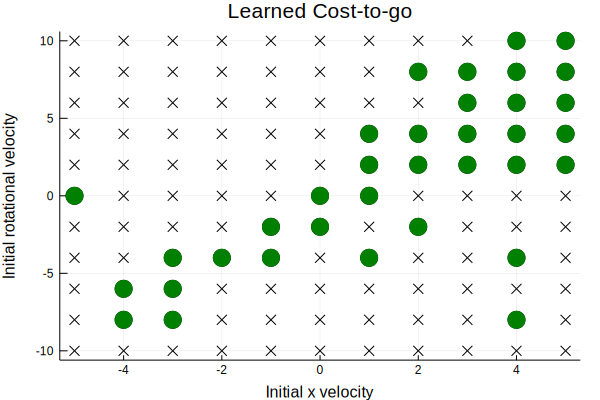

In [100]:
plt = plot(legend=false)
for row in eachrow(table)
    if row[:controller] == "net_mpc"
        success = -π/4 <= row[:qf][3] <= π/4
        if success
            scatter!(plt, [row[:v0][1]], [row[:v0][3]], color = "green", marker = :dot, markersize = 10)
        else
            scatter!(plt, [row[:v0][1]], [row[:v0][3]], color = "red", marker = :x)
        end
    end
end
title!(plt, "Learned Cost-to-go")
xlabel!(plt, "Initial x velocity")
ylabel!(plt, "Initial rotational velocity")
savefig(plt, "learned-cost-evaluation.svg")
plt

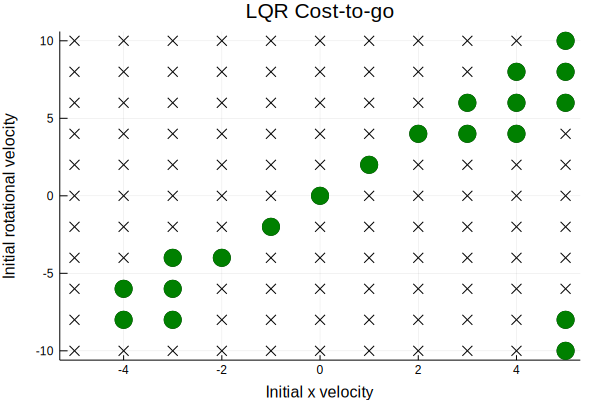

In [101]:
plt = plot(legend=false)
for row in eachrow(table)
    if row[:controller] == "lqr_mpc"
        success = -π/4 <= row[:qf][3] <= π/4
        if success
            scatter!(plt, [row[:v0][1]], [row[:v0][3]], color = "green", marker = :dot, markersize = 10)
        else
            scatter!(plt, [row[:v0][1]], [row[:v0][3]], color = "red", marker = :x)
        end
    end
end
title!(plt, "LQR Cost-to-go")
xlabel!(plt, "Initial x velocity")
ylabel!(plt, "Initial rotational velocity")
savefig(plt, "lqr-cost-evaluation.svg")
plt

In [119]:
cost_table = LearningMPC.run_evaluations(
    lqr_param_mpc,
    "lqr_mpc",
    robot,
    lqrsol,
    [(1, [0])],
    [(1, linspace(-1.5, 1.5, 31))]; 
    mvis=mvis
)

append!(cost_table, 
LearningMPC.run_evaluations(
    mpc,
    "net_mpc",
    robot,
    lqrsol,
    [(1, [0])],
    [(1, linspace(-1.5, 1.5, 31))];
        mvis = mvis
)
)

cost_table

Progress: 100%|█████████████████████████████████████████| Time: 0:03:57
Progress:  10%|████                                     |  ETA: 0:03:37WARNING: Instability detected. Aborting
Progress: 100%|█████████████████████████████████████████| Time: 0:04:12


,controller,q0,v0,Δt,horizon,qf,vf,running_cost,terminal_cost
1,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-1.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[-2.65259, -0.32046, 3.06881, 0.0856363, 0.024727, 0.585203, 0.623658, 0.800134, 0.749079, 0.474999, 0.474963]","[0.0439318, 0.18169, 0.524312, 0.278877, 0.0183375, -2.48896, 0.131432, 0.00104815, 0.263444, 0.0325584, 0.0199603]",8842.71,46352.8
2,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-1.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[-2.76997, -0.292865, 3.00859, 0.0997376, 0.0103303, 0.666214, 0.702765, 0.800034, 0.790161, 0.487214, 0.494192]","[0.432235, -0.602242, -0.999384, 0.107988, -0.327545, -0.95739, -0.934362, -0.0238769, -0.408414, 0.153181, -0.0574279]",9148.77,46162.5
3,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-1.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[-2.82615, -0.324553, 3.09389, 0.130661, -3.43813e-5, 0.580074, 0.676043, 0.800186, 0.761263, 0.474695, 0.474955]","[0.996356, -0.213724, 1.13492, 1.80912, 0.0395163, 3.79877, -1.74375, -0.0867382, 0.289142, 0.098527, -0.587242]",8516.6,49627.0
4,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-1.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[-2.49701, -0.336307, 3.14145, 0.200934, 0.0048945, 0.457423, 0.504826, 0.800355, 0.799421, 0.489207, 0.476816]","[0.556581, 0.199357, -0.461744, 0.479417, 0.254039, -0.262818, 1.15252, 0.1247, -0.187869, -0.146475, -0.081235]",8345.89,45429.2
5,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-1.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[-2.56662, -0.32722, 3.18453, 0.338234, 0.00983988, 0.195339, 0.752916, 0.799986, 0.790736, 0.737131, 0.478878]","[-0.255945, -0.0566881, -0.879747, -0.991896, 0.723063, -2.49789, 1.50353, -0.00149551, -0.449134, 1.50462, 0.0723718]",7350.55,43852.2
6,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[-1.71015, -0.32983, 3.08763, 0.0715018, 0.361388, 0.474331, 0.51684, 0.800266, 0.800065, 0.474954, 0.474961]","[-0.0369187, -0.273841, -0.0845726, -0.0772439, 0.196873, 0.151967, 2.73129, -0.0475074, -0.0422726, 0.018579, -0.00478652]",7188.85,35757.6
7,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-0.9, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[-2.14022, -0.321047, 3.13043, 0.23952, 0.134448, 0.186499, 0.678051, 0.799992, 0.77261, 0.624445, 0.484373]","[-0.326451, -0.125718, -1.36272, -0.922316, 1.10498, -2.56711, 0.0547544, -0.00194968, -0.533836, 1.50919, -0.00170652]",6574.6,38513.2
8,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-0.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[-2.11382, -0.341077, 3.1286, 0.121077, 0.136461, 0.177482, 0.534705, 0.800359, 0.794312, 0.579232, 0.474878]","[1.19247, -0.0641213, 1.15178, 2.01597, -2.08492, 4.52856, -3.78538, -0.0675912, -0.14681, -4.58316, 0.0904353]",6435.45,41012.7
9,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-0.7, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[-2.03007, -0.285852, 3.25015, 0.0682783, 0.110216, -0.0390654, 0.7854, 0.790464, 0.797841, 0.922823, 0.474977]","[0.638154, 0.982149, -2.23527, -0.157463, 0.170017, 0.149345, -0.00193374, -0.370556, -0.137565, -1.19226, 0.0526875]",6697.02,37175.7
10,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[-1.69632, -0.327697, 3.09115, 0.0901911, 0.263716, 0.115137, 0.615465, 0.800009, 0.77914, 0.850269, 0.474998]","[0.362697, 0.0445736, 0.274268, 0.581552, -0.544258, 0.804237, -0.832427, -0.00271408, -0.254276, -1.0885, 0.000384638]",5406.79,33396.1


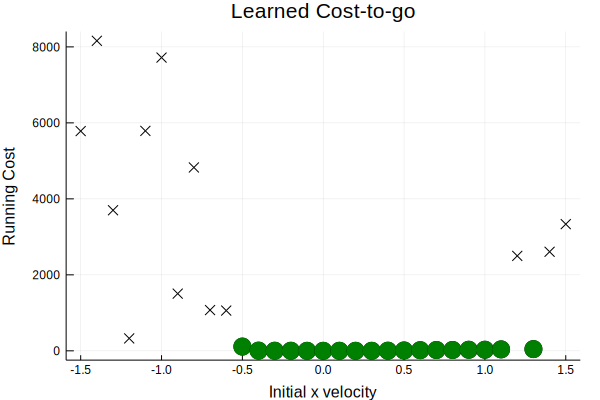

In [120]:
plt = plot(legend=false)
for row in eachrow(cost_table)
    if row[:controller] == "net_mpc"
        success = -π/4 <= row[:qf][3] <= π/4
        if success
            scatter!(plt, [row[:v0][1]], [row[:running_cost][1]], color = "green", marker = :dot, markersize = 10)
        else
            scatter!(plt, [row[:v0][1]], [row[:running_cost][1]], color = "red", marker = :x)
        end
    end
end
title!(plt, "Learned Cost-to-go")
xlabel!(plt, "Initial x velocity")
ylabel!(plt, "Running Cost")
savefig(plt, "learned-cost-evaluation.svg")
plt

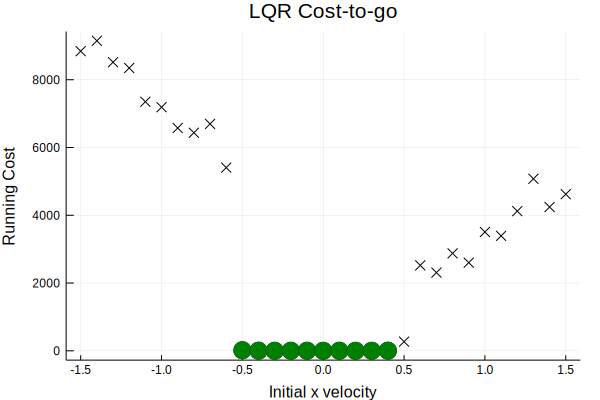

In [121]:
plt = plot(legend=false)
for row in eachrow(cost_table)
    if row[:controller] == "lqr_mpc"
        success = -π/4 <= row[:qf][3] <= π/4
        if success
            scatter!(plt, [row[:v0][1]], [row[:running_cost][1]], color = "green", marker = :dot, markersize = 10)
        else
            scatter!(plt, [row[:v0][1]], [row[:running_cost][1]], color = "red", marker = :x)
        end
    end
end
title!(plt, "LQR Cost-to-go")
xlabel!(plt, "Initial x velocity")
ylabel!(plt, "Running Cost")
savefig(plt, "lqr-cost-evaluation.svg")
plt